パッケージのインポート

In [1]:
import requests as rq
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import folium

connpass APIを使ってデータを取得する関数

引数

* kw  : キーワード

* typ : タイプ(全勉強会対象, \#stapy限定)

In [2]:
def fetchStudyGroupData(kw,typ):

    url = 'https://connpass.com/api/v1/event/'

    # params
    count = '100'

    # イベント名
    title = []
    # 開催日
    date = []
    # グループ名
    grpNm = []
    # 緯度
    lat = []
    # 経度
    lon = []
    # 会場
    place = []
    # 参加者数
    accptd = []
    # 定員
    limit = []
    # 補欠者数
    waiting = []
    # 年月
    ymList = []
    # 開催数
    available  = []

    for yr in tqdm(range(2011,2018)):
        for mth in range(1,13):
            if yr == 2017 and mth >= 3:
                break
            ym = str(yr)+str(mth)
            payload = {'keyword_or':kw,'count':count,'ym':ym}
            # dictで受け取る
            res = rq.get(url,params=payload).json()

            ymList.append(str(yr)+str(mth).zfill(2))
            available.append(res['results_available'])

            # 取得件数が1件のときのみ実行
            if res['results_returned'] > 0:

                for v in res['events']:
                    title.append([v['title']])
                    date.append(v['started_at'][0:10])
                    lat.append(v['lat'])
                    lon.append(v['lon'])
                    place.append(v['place'])
                    accptd.append(v['accepted'])
                    limit.append(v['limit'])
                    waiting.append(v['waiting'])
                    if v['series'] is not None:
                        grpNm.append(v['series']['title'])
                    else:
                        grpNm.append(' ')
            time.sleep(0.25)


    resultNum = {'ym':ymList,'availableEvents':available}
    dfResults = pd.DataFrame.from_dict(resultNum)
    dfResults.to_csv('data/' + typ + '_availableEvents_-201702.csv')

    events = {'title':title,'date':date,'groupNm':grpNm,'lat':lat,'lon':lon,'place':place,'accepted':accptd,'limit':limit,'waiting':waiting}
    dfEvents = pd.DataFrame.from_dict(events)
    dfEvents.to_csv('data/' + typ + '_eventStats_-201702.csv')

全勉強会・#stapyのデータを取得

In [3]:
keyword = ['python']
typ = 'all'
fetchStudyGroupData(keyword,typ)
time.sleep(5)
keyword = ['みんなのPython勉強会','業務のためのPython勉強会']
typ = 'stapy'
fetchStudyGroupData(keyword,typ)

100%|██████████| 7/7 [01:16<00:00, 10.68s/it]


matplotlibに日本語を設定するためにfont一覧を取得

[参考](http://qiita.com/kshigeru/items/0cfc0778bab197687967)

In [4]:
import matplotlib.font_manager as fm
fonts = fm.findSystemFonts()
l = []
for f in fonts:
    font = fm.FontProperties(fname=f)
    l.append((f, font.get_name(), font.get_family()))
fonts = pd.DataFrame(l, columns=['path', 'name', 'family'])
fonts[fonts['path'].apply(lambda s: 'Takao' in s)]

,path,name,family
56,/usr/share/fonts/truetype/takao-mincho/TakaoPM...,TakaoPMincho,[sans-serif]
61,/usr/share/fonts/truetype/takao-gothic/TakaoGo...,TakaoGothic,[sans-serif]
66,/usr/share/fonts/truetype/takao-gothic/TakaoEx...,TakaoExGothic,[sans-serif]
93,/usr/share/fonts/truetype/takao-mincho/TakaoMi...,TakaoMincho,[sans-serif]
123,/usr/share/fonts/truetype/takao-mincho/TakaoEx...,TakaoExMincho,[sans-serif]
210,/usr/share/fonts/truetype/takao-gothic/TakaoPG...,TakaoPGothic,[sans-serif]


\#stapyの満席率の推移をグラフ化

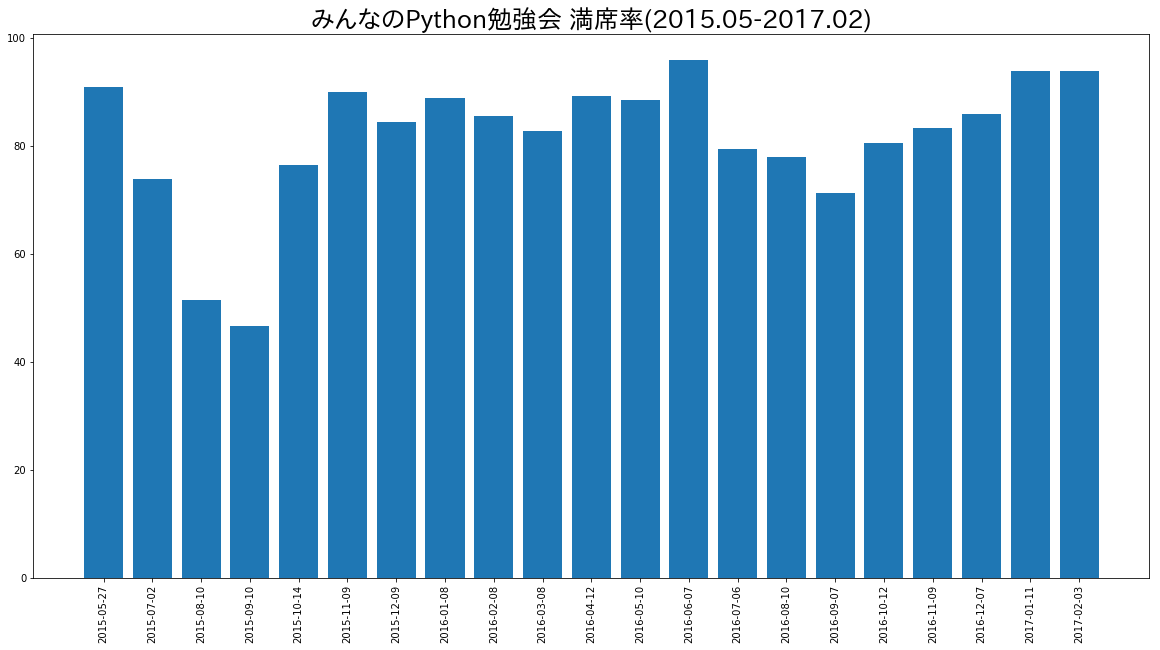

満席率平均:fillrate    81.502005
dtype: float64


,date,title
0,2015-05-27,['業務のためのPython勉強会']
1,2015-07-02,['業務のためのPython勉強会#2']
2,2015-08-10,['業務のためのPython勉強会#3']
3,2015-09-10,['業務のためのPython勉強会#4']
4,2015-10-14,['業務のためのPython勉強会#5']
5,2015-11-09,['みんなのPython勉強会#6']
6,2015-12-09,['みんなのPython勉強会#7']
7,2016-01-08,['みんなのPython勉強会#8']
8,2016-02-08,['みんなのPython勉強会#9']
9,2016-03-08,['みんなのPython勉強会#10']


In [5]:
df = pd.read_csv('data/stapy_eventStats_-201702.csv')
date = []
title = []
fillrate = []
for idx,row in df.iterrows():
    if row['groupNm'] == 'Start Python Club':
        title.append(row['title'])
        date.append(row['date'])
        popularity = (row['accepted']/row['limit'])*100
        fillrate.append(popularity)
d = {'date':date,'title':title}
titles = pd.DataFrame.from_dict(d)
titles

xaxis = []
for x in range(len(title)):
    xaxis.append(x)
    
plt.figure(figsize=(20,10))
plt.bar(xaxis,fillrate)
plt.xticks(xaxis,date,rotation='vertical')
plt.title('みんなのPython勉強会 満席率(2015.05-2017.02)',fontdict={'family':'TakaoPGothic'},fontsize=25)
plt.savefig('img/stapyFillrate.png',transperent=False)
plt.show()

fillrates = pd.DataFrame({'fillrate':fillrate})
print('満席率平均:',end="")
print(fillrates.mean())
titles

満席率の平均は81.5%

初期は"業務のためのPython勉強会"だった.

---

Python勉強会開催数の推移をグラフ化

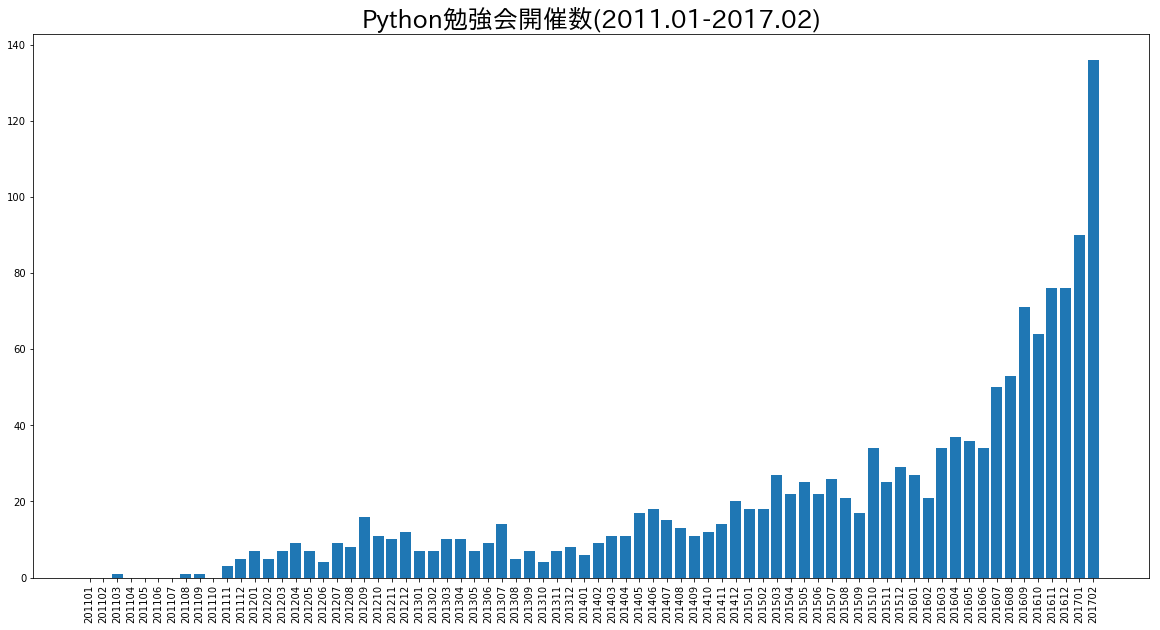

In [6]:
fin =  open('data/all_availableEvents_-201702.csv')
df = pd.read_csv(fin)
ym = []
available = []

for idx,row in df.iterrows():
    ym.append(row['ym'])
    available.append(row['availableEvents'])
# plt.clf()
plt.figure(figsize=(20,10))
x = []
for i in range(len(ym)):
    x.append(i)
plt.bar(x,available)
plt.title("Python勉強会開催数(2011.01-2017.02)",fontdict={'family':'TakaoPGothic'},fontsize=25)
plt.xticks(x,ym,rotation="vertical")
plt.savefig('img/pythonStudies.png',transperent=False)
plt.show()

2016年中頃からの伸びが大きい.

2017年2月に100件を突破.

---

勉強会会場をマッピングしてみる

やはり都心部が多い. 新宿・渋谷・半蔵門・秋葉原周辺で継続的に開催されているみたい.

In [7]:
import folium

df = pd.read_csv('data/all_eventStats_-201702.csv')

tokyo = (35.658034, 139.701636)

m = folium.Map(location=tokyo,zoom_start=10)
cluster = folium.MarkerCluster("cluster")
# nanがあるとそこでmarker追加が終わるため, 緯度がnanの行を削除
df_map = df.dropna(subset=['lat'])
for idx,row in df_map.iterrows():
    if row['lat'] is not None and row['lon'] is not None:
        text = row['title'] + "\n" + row['place']
        coord = [row['lat'],row['lon']]
        marker = folium.Marker(coord,popup=text).add_to(cluster)
m.add_children(cluster)
        
m.save('docs/index.html')
m